In [3]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

Mounted at /content/drive


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [73]:
print("Часть 1\n")


df = pd.read_csv('/content/drive/MyDrive/HW1_var_7.csv', sep=';', encoding='utf-8')
print("Размер данных:", df.shape)

print(df.info())
print(df.head())
print(df.describe(include='all'))

Часть 1

Размер данных: (10243, 44)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10243 entries, 0 to 10242
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Номер варианта         10243 non-null  int64  
 1   ID                     10243 non-null  int64  
 2   INCOME_BASE_TYPE       10180 non-null  object 
 3   CREDIT_PURPOSE         10243 non-null  object 
 4   INSURANCE_FLAG         10243 non-null  int64  
 5   DTI                    10120 non-null  float64
 6   SEX                    10243 non-null  object 
 7   FULL_AGE_CHILD_NUMBER  10243 non-null  int64  
 8   DEPENDANT_NUMBER       10243 non-null  int64  
 9   EDUCATION              10243 non-null  object 
 10  EMPL_TYPE              10232 non-null  object 
 11  EMPL_SIZE              10121 non-null  object 
 12  BANKACCOUNT_FLAG       7908 non-null   float64
 13  Period_at_work         7906 non-null   float64
 14  age               

In [74]:
missing_data = pd.DataFrame({
    'Кол-во пропусков': df.isnull().sum(),
    '% пропусков': (df.isnull().sum() / len(df)) * 100
})
print(missing_data.sort_values('% пропусков', ascending=False))

unique_zeros_analysis = pd.DataFrame({
    'Уникальных значений': df.nunique(),
    'Кол-во нулей': (df == 0).sum(),
    '% нулей': ((df == 0).sum() / len(df)) * 100
})
print(unique_zeros_analysis)

                       Кол-во пропусков  % пропусков
avg_num_delay                      6655    64.971200
all_credits                        6641    64.834521
own_closed                         6641    64.834521
Active_not_cc                      6641    64.834521
max_MnthAfterLoan                  6641    64.834521
dlq_exist                          6641    64.834521
thirty_in_a_year                   6641    64.834521
num_AccountActive60                6641    64.834521
num_AccountActive180               6641    64.834521
num_AccountActive90                6641    64.834521
if_zalog                           6641    64.834521
min_MnthAfterLoan                  6641    64.834521
ninety_in_a_year                   6641    64.834521
thirty_vintage                     6641    64.834521
sixty_vintage                      6641    64.834521
sixty_in_a_year                    6641    64.834521
ninety_vintage                     6641    64.834521
numAccountClosed                   6641    64.

In [75]:
low_missing_columns = [
    'ID', 'INCOME_BASE_TYPE', 'CREDIT_PURPOSE', 'INSURANCE_FLAG', 'DTI',
    'SEX', 'FULL_AGE_CHILD_NUMBER', 'DEPENDANT_NUMBER', 'EDUCATION',
    'EMPL_TYPE', 'EMPL_SIZE'
]

df_for_segmentation = df[low_missing_columns].copy()
print(f"Исходный размер: {df_for_segmentation.shape}")

print("\nПропуски перед обработкой:")
print(df_for_segmentation.isnull().sum())

df_for_segmentation['INCOME_BASE_TYPE'].fillna('Не указано', inplace=True)
df_for_segmentation['EMPL_TYPE'].fillna('Не указано', inplace=True)
df_for_segmentation['EMPL_SIZE'].fillna('Не указано', inplace=True)
df_for_segmentation['DTI'].fillna(df_for_segmentation['DTI'].median(), inplace=True)

print(f"\nПосле обработки пропусков: {df_for_segmentation.isnull().sum().sum()} пропусков осталось")

print("\n=== КАТЕГОРИАЛЬНЫЕ ПЕРЕМЕННЫЕ ===")
categorical_cols = ['INCOME_BASE_TYPE', 'CREDIT_PURPOSE', 'SEX', 'EDUCATION', 'EMPL_TYPE', 'EMPL_SIZE']
for col in categorical_cols:
    print(f"\n{col}: {df_for_segmentation[col].nunique()} уникальных значений")
    print(df_for_segmentation[col].value_counts().head())

Исходный размер: (10243, 11)

Пропуски перед обработкой:
ID                         0
INCOME_BASE_TYPE          63
CREDIT_PURPOSE             0
INSURANCE_FLAG             0
DTI                      123
SEX                        0
FULL_AGE_CHILD_NUMBER      0
DEPENDANT_NUMBER           0
EDUCATION                  0
EMPL_TYPE                 11
EMPL_SIZE                122
dtype: int64

После обработки пропусков: 0 пропусков осталось

=== КАТЕГОРИАЛЬНЫЕ ПЕРЕМЕННЫЕ ===

INCOME_BASE_TYPE: 5 уникальных значений
INCOME_BASE_TYPE
2НДФЛ                                     3281
Поступление зарплаты на счет              3101
Форма банка (без печати работодателя)     2923
Свободная форма с печатью работодателя     875
Не указано                                  63
Name: count, dtype: int64

CREDIT_PURPOSE: 10 уникальных значений
CREDIT_PURPOSE
Ремонт                                 5689
Покупка автомобиля                     1755
Покупка недвижимости/ строительство    1376
Отпуск               

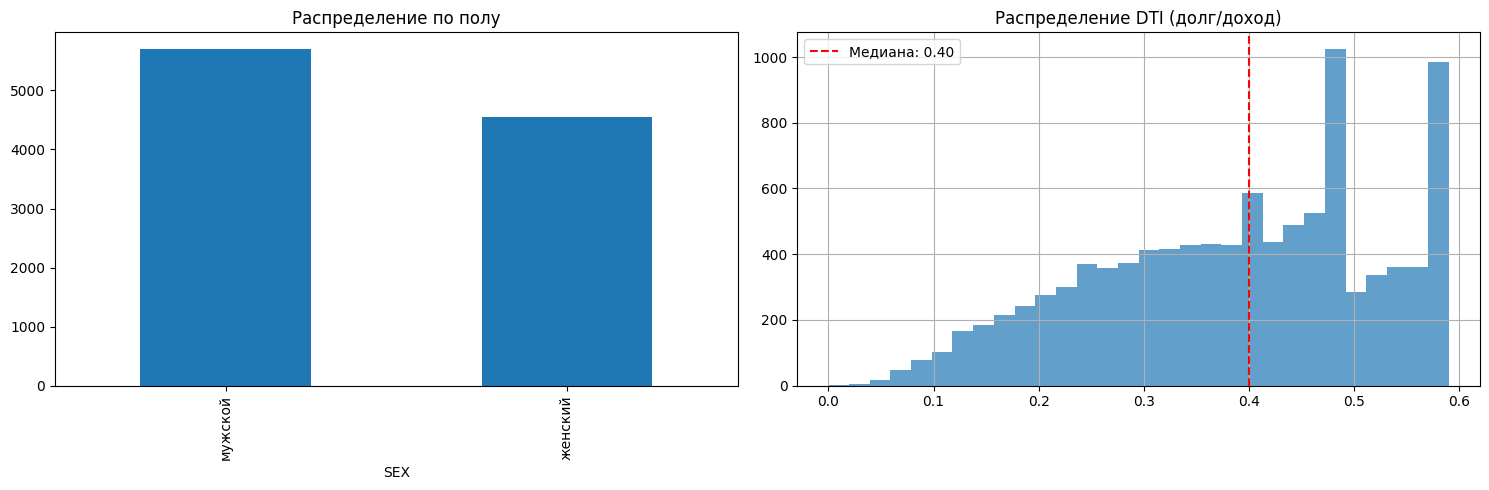

In [76]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

df_for_segmentation['SEX'].value_counts().plot(kind='bar', ax=ax1, title='Распределение по полу')

df_for_segmentation['DTI'].hist(bins=30, ax=ax2, alpha=0.7)
ax2.set_title('Распределение DTI (долг/доход)')
ax2.axvline(df_for_segmentation['DTI'].median(), color='red', linestyle='--', label=f'Медиана: {df_for_segmentation["DTI"].median():.2f}')
ax2.legend()

plt.tight_layout()
plt.show()

In [77]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df_for_segmentation.copy()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"{col} закодирован: {len(le.classes_)} категорий")

df_encoded = df_encoded.drop('ID', axis=1)

print(f"\nФинальный датасет для сегментации: {df_encoded.shape}")
print("Столбцы:", df_encoded.columns.tolist())

INCOME_BASE_TYPE закодирован: 5 категорий
CREDIT_PURPOSE закодирован: 10 категорий
SEX закодирован: 2 категорий
EDUCATION закодирован: 9 категорий
EMPL_TYPE закодирован: 10 категорий
EMPL_SIZE закодирован: 8 категорий

Финальный датасет для сегментации: (10243, 10)
Столбцы: ['INCOME_BASE_TYPE', 'CREDIT_PURPOSE', 'INSURANCE_FLAG', 'DTI', 'SEX', 'FULL_AGE_CHILD_NUMBER', 'DEPENDANT_NUMBER', 'EDUCATION', 'EMPL_TYPE', 'EMPL_SIZE']


In [78]:
print("Итоги:")
print(f"Размер данных: {df_encoded.shape}")
print(f"Пропуски: {df_encoded.isnull().sum().sum()}")
print(f"Типы данных:\n{df_encoded.dtypes}")

Итоги:
Размер данных: (10243, 10)
Пропуски: 0
Типы данных:
INCOME_BASE_TYPE           int64
CREDIT_PURPOSE             int64
INSURANCE_FLAG             int64
DTI                      float64
SEX                        int64
FULL_AGE_CHILD_NUMBER      int64
DEPENDANT_NUMBER           int64
EDUCATION                  int64
EMPL_TYPE                  int64
EMPL_SIZE                  int64
dtype: object


In [79]:
print("Часть 2\n")


rfm_table_clean = df_for_segmentation.copy()

rfm_table_clean['R'] = rfm_table_clean['DTI']

rfm_table_clean['F'] = rfm_table_clean['FULL_AGE_CHILD_NUMBER'] + rfm_table_clean['DEPENDANT_NUMBER'] + rfm_table_clean['INSURANCE_FLAG']

education_rank = {
    'Не указано': 1, 'среднее': 2, 'среднее-специальное': 3,
    'высшее': 4, 'второе высшее': 5, 'Высшее/Второе высшее/Ученая степень': 6
}
employment_rank = {
    'Не указано': 1, 'рабочий': 2, 'вспомогательный персонал': 3,
    'специалист': 4, 'менеджер среднего звена': 5, 'менеджер высшего звена': 6
}
company_size_rank = {
    'Не указано': 1, '< 50': 2, '>=50': 3, '>=200': 4, '>100': 4, '>250': 5
}

rfm_table_clean['M'] = (
    rfm_table_clean['EDUCATION'].map(education_rank) +
    rfm_table_clean['EMPL_TYPE'].map(employment_rank) +
    rfm_table_clean['EMPL_SIZE'].map(company_size_rank)
)

rfm_table_clean['M'] = rfm_table_clean['M'].fillna(rfm_table_clean['M'].median())

rfm_table_clean['R_Score'] = pd.qcut(rfm_table_clean['R'], q=4, labels=[4, 3, 2, 1])
rfm_table_clean['F_Score'] = pd.qcut(rfm_table_clean['F'].rank(method='first'), q=4, labels=[1, 2, 3, 4])
rfm_table_clean['M_Score'] = pd.qcut(rfm_table_clean['M'], q=4, labels=[1, 2, 3, 4])

def get_clean_rfm_segment(row):
    r, f, m = int(row['R_Score']), int(row['F_Score']), int(row['M_Score'])
    total_score = r + f + m

    if total_score >= 11:
        return 'VIP клиенты'
    elif total_score >= 9:
        return 'Лояльные клиенты'
    elif total_score >= 7:
        return 'Стабильные клиенты'
    elif total_score >= 5:
        return 'Новые клиенты'
    else:
        return 'Эконом клиенты'

rfm_table_clean['RFM_Segment'] = rfm_table_clean.apply(get_clean_rfm_segment, axis=1)

print("RFM-сегментация:")
clean_rfm_counts = rfm_table_clean['RFM_Segment'].value_counts()
for segment, count in clean_rfm_counts.items():
    print(f"{segment}: {count} клиентов ({count/len(rfm_table_clean)*100:.1f}%)")

Часть 2

RFM-сегментация:
Стабильные клиенты: 4040 клиентов (39.4%)
Новые клиенты: 2831 клиентов (27.6%)
Лояльные клиенты: 2297 клиентов (22.4%)
Эконом клиенты: 577 клиентов (5.6%)
VIP клиенты: 498 клиентов (4.9%)


In [80]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_encoded)

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_data)

rfm_table_clean['KMeans_Cluster'] = clusters

print("Распределение K-Means:")
cluster_counts = pd.Series(clusters).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"Кластер {cluster}: {count} клиентов ({count/len(clusters)*100:.1f}%)")

Распределение K-Means:
Кластер 0: 1387 клиентов (13.5%)
Кластер 1: 2408 клиентов (23.5%)
Кластер 2: 2899 клиентов (28.3%)
Кластер 3: 27 клиентов (0.3%)
Кластер 4: 3522 клиентов (34.4%)


In [81]:
final_results = rfm_table_clean.copy()

print(f"Всего клиентов: {len(final_results)}")

print("\nRFM:")
rfm_final = final_results['RFM_Segment'].value_counts()
for segment, count in rfm_final.items():
    print(f"  {segment}: {count} ({count/len(final_results)*100:.1f}%)")

print("\nK-means:")
kmeans_final = final_results['KMeans_Cluster'].value_counts().sort_index()
for cluster, count in kmeans_final.items():
    print(f"  Кластер {cluster}: {count} ({count/len(final_results)*100:.1f}%)")

Всего клиентов: 10243

RFM:
  Стабильные клиенты: 4040 (39.4%)
  Новые клиенты: 2831 (27.6%)
  Лояльные клиенты: 2297 (22.4%)
  Эконом клиенты: 577 (5.6%)
  VIP клиенты: 498 (4.9%)

K-means:
  Кластер 0: 1387 (13.5%)
  Кластер 1: 2408 (23.5%)
  Кластер 2: 2899 (28.3%)
  Кластер 3: 27 (0.3%)
  Кластер 4: 3522 (34.4%)


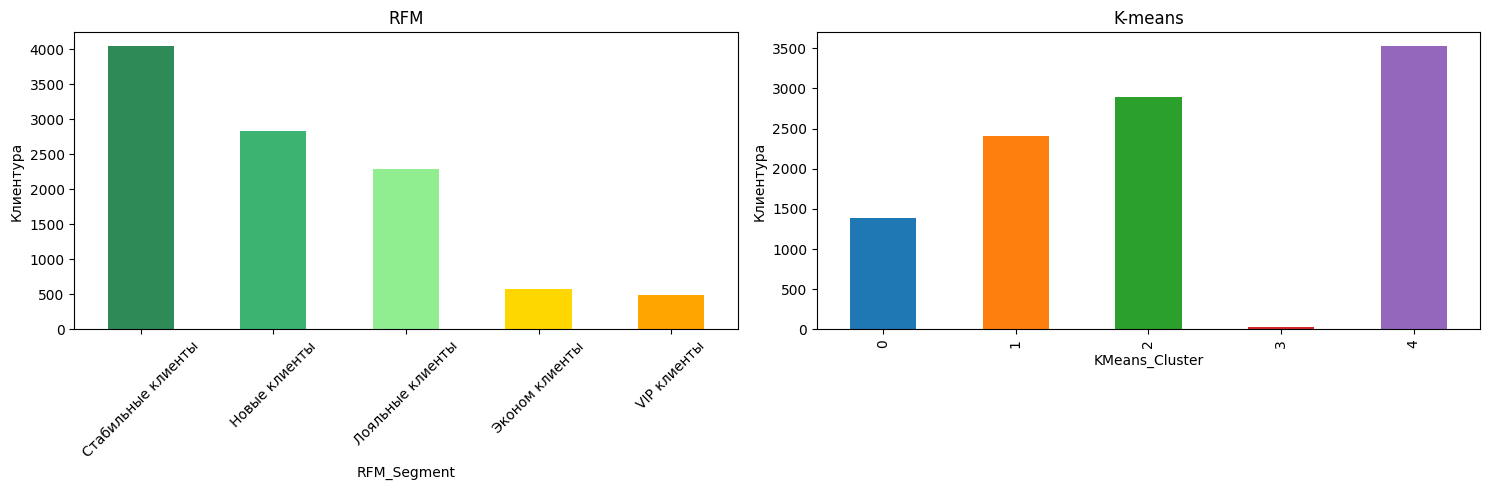

In [82]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

colors_rfm = ['#2E8B57', '#3CB371', '#90EE90', '#FFD700', '#FFA500']
rfm_final.plot(kind='bar', ax=ax1, color=colors_rfm)
ax1.set_title('RFM')
ax1.set_ylabel('Клиентура')
ax1.tick_params(axis='x', rotation=45)

colors_kmeans = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
kmeans_final.plot(kind='bar', ax=ax2, color=colors_kmeans)
ax2.set_title('K-means')
ax2.set_ylabel('Клиентура')

plt.tight_layout()
plt.show()

In [83]:
print("Часть 3\n")


from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

k_range = range(2, 11)
results = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(scaled_data)

    inertia = kmeans.inertia_
    silhouette = silhouette_score(scaled_data, clusters)
    calinski = calinski_harabasz_score(scaled_data, clusters)
    davies = davies_bouldin_score(scaled_data, clusters)

    results.append({
        'k': k,
        'inertia': inertia,
        'silhouette': silhouette,
        'calinski': calinski,
        'davies': davies
    })

    print(f"k={k}: Inertia={inertia:.0f}, Silhouette={silhouette:.3f}, Calinski={calinski:.0f}, Davies={davies:.3f}")

results_df = pd.DataFrame(results)
print("\nСводная таблица метрик:")
print(results_df.round(3))

Часть 3

k=2: Inertia=91881, Silhouette=0.123, Calinski=1176, Davies=2.692
k=3: Inertia=85591, Silhouette=0.113, Calinski=1007, Davies=2.495
k=4: Inertia=77403, Silhouette=0.124, Calinski=1104, Davies=1.982
k=5: Inertia=72761, Silhouette=0.117, Calinski=1044, Davies=1.938
k=6: Inertia=68443, Silhouette=0.109, Calinski=1017, Davies=1.932
k=7: Inertia=64632, Silhouette=0.108, Calinski=998, Davies=1.820
k=8: Inertia=62511, Silhouette=0.105, Calinski=934, Davies=1.698
k=9: Inertia=59970, Silhouette=0.113, Calinski=906, Davies=1.737
k=10: Inertia=58322, Silhouette=0.113, Calinski=860, Davies=1.662

Сводная таблица метрик:
    k    inertia  silhouette  calinski  davies
0   2  91880.745       0.123  1175.817   2.692
1   3  85590.941       0.113  1007.303   2.495
2   4  77402.871       0.124  1103.546   1.982
3   5  72761.102       0.117  1043.656   1.938
4   6  68442.961       0.109  1016.712   1.932
5   7  64631.743       0.108   997.712   1.820
6   8  62510.505       0.105   933.734   1.698

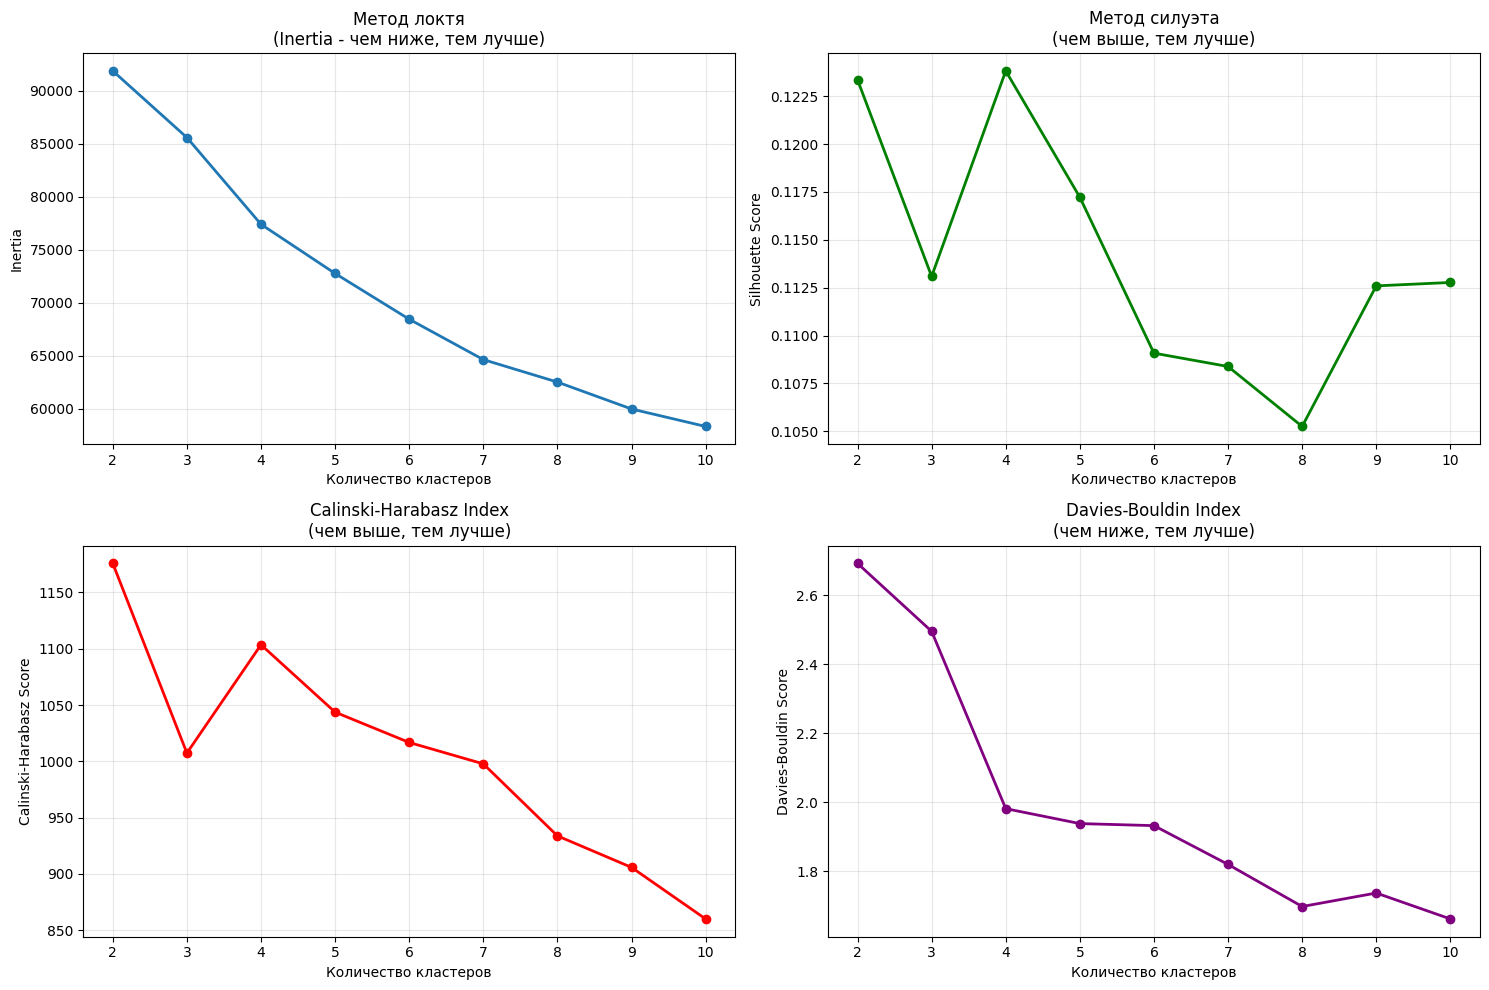

In [84]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.plot(results_df['k'], results_df['inertia'], marker='o', linewidth=2)
ax1.set_title('Метод локтя\n(Inertia - чем ниже, тем лучше)')
ax1.set_xlabel('Количество кластеров')
ax1.set_ylabel('Inertia')
ax1.grid(True, alpha=0.3)

ax2.plot(results_df['k'], results_df['silhouette'], marker='o', linewidth=2, color='green')
ax2.set_title('Метод силуэта\n(чем выше, тем лучше)')
ax2.set_xlabel('Количество кластеров')
ax2.set_ylabel('Silhouette Score')
ax2.grid(True, alpha=0.3)

ax3.plot(results_df['k'], results_df['calinski'], marker='o', linewidth=2, color='red')
ax3.set_title('Calinski-Harabasz Index\n(чем выше, тем лучше)')
ax3.set_xlabel('Количество кластеров')
ax3.set_ylabel('Calinski-Harabasz Score')
ax3.grid(True, alpha=0.3)

ax4.plot(results_df['k'], results_df['davies'], marker='o', linewidth=2, color='purple')
ax4.set_title('Davies-Bouldin Index\n(чем ниже, тем лучше)')
ax4.set_xlabel('Количество кластеров')
ax4.set_ylabel('Davies-Bouldin Score')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Анализ полученных метрик**

1. Метод силуэта:
   - лучшее число кластеров: k=4 (0.124)

2. Calinski-Harabaz:
   - лучшее число кластеров: k=2 (1176)

3. Davies-Bouldin:
   - лучшее число кластеров: k=10 (1.662)

4. Метод локтя:
   - После k=5 уменьшение замедляется

Почему я выбрал k=5?

Во-первых, задание требует минимум 5 кластеров
Во-вторых, при k=5 все метрики показывают сбалансированные (средние) показатели без "странных" взлетов или падений значений метрики
В-третьих, больше кластеров могут стать для обучения статистическим шумом

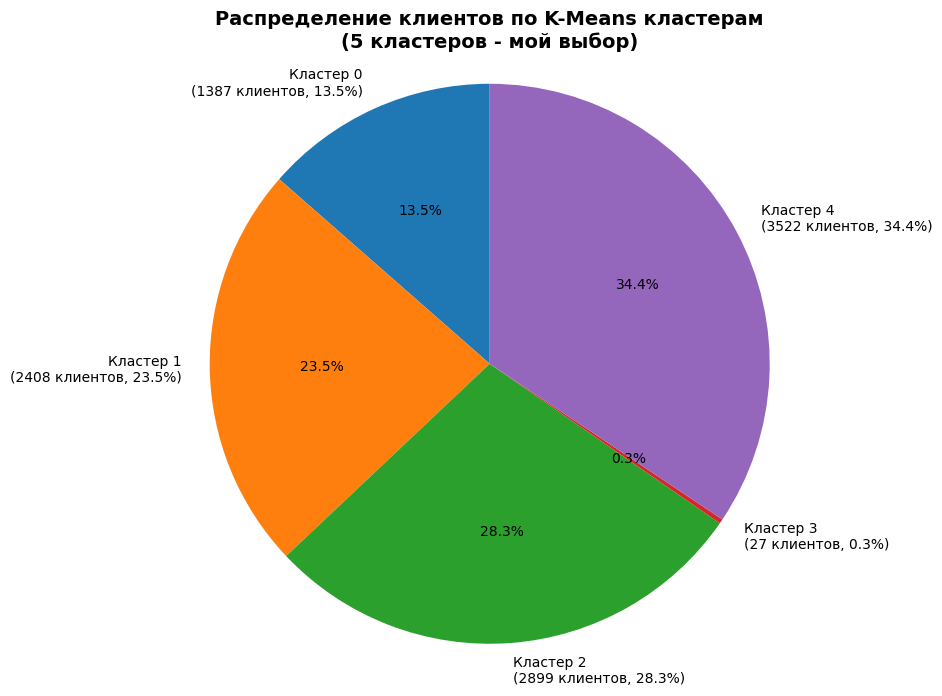

In [85]:
plt.figure(figsize=(10, 8))
plt.pie(kmeans_final.values,
        labels=[f'Кластер {k}\n({v} клиентов, {v/len(final_results)*100:.1f}%)' for k, v in kmeans_final.items()],
        autopct='%1.1f%%', startangle=90, colors=colors_kmeans)
plt.title('Распределение клиентов по K-Means кластерам\n(5 кластеров - мой выбор)',
          fontsize=14, fontweight='bold')
plt.axis('equal')
plt.show()

In [86]:
print("Часть 4\n")


rfm_profiles = final_results.groupby('RFM_Segment').agg({
    'DTI': ['mean', 'std'],
    'FULL_AGE_CHILD_NUMBER': 'mean',
    'DEPENDANT_NUMBER': 'mean',
    'INSURANCE_FLAG': 'mean',
    'SEX': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено',
    'EDUCATION': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено',
    'EMPL_TYPE': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено',
    'EMPL_SIZE': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено',
    'INCOME_BASE_TYPE': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено',
    'CREDIT_PURPOSE': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено'
}).round(3)

rfm_sizes = final_results['RFM_Segment'].value_counts()
rfm_profiles['Размер'] = rfm_sizes
rfm_profiles['%'] = (rfm_sizes / len(final_results) * 100).round(1)

print(rfm_profiles)

Часть 4

                      DTI        FULL_AGE_CHILD_NUMBER DEPENDANT_NUMBER  \
                     mean    std                  mean             mean   
RFM_Segment                                                               
VIP клиенты         0.232  0.086                 1.402            0.002   
Лояльные клиенты    0.299  0.123                 0.913            0.007   
Новые клиенты       0.463  0.103                 0.239            0.002   
Стабильные клиенты  0.387  0.126                 0.559            0.004   
Эконом клиенты      0.527  0.054                 0.050            0.002   

                   INSURANCE_FLAG      SEX EDUCATION                EMPL_TYPE  \
                             mean <lambda>  <lambda>                 <lambda>   
RFM_Segment                                                                     
VIP клиенты                 0.685  мужской    высшее  менеджер среднего звена   
Лояльные клиенты            0.689  мужской    высшее              

In [87]:
kmeans_profiles = final_results.groupby('KMeans_Cluster').agg({
    'DTI': ['mean', 'std'],
    'FULL_AGE_CHILD_NUMBER': 'mean',
    'DEPENDANT_NUMBER': 'mean',
    'INSURANCE_FLAG': 'mean',
    'SEX': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено',
    'EDUCATION': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено',
    'EMPL_TYPE': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено',
    'EMPL_SIZE': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено',
    'INCOME_BASE_TYPE': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено',
    'CREDIT_PURPOSE': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Не определено'
}).round(3)

kmeans_sizes = final_results['KMeans_Cluster'].value_counts().sort_index()
kmeans_profiles['Размер'] = kmeans_sizes
kmeans_profiles['%'] = (kmeans_sizes / len(final_results) * 100).round(1)
print(kmeans_profiles)

                  DTI        FULL_AGE_CHILD_NUMBER DEPENDANT_NUMBER  \
                 mean    std                  mean             mean   
KMeans_Cluster                                                        
0               0.383  0.139                 2.152            0.000   
1               0.411  0.137                 0.293            0.000   
2               0.389  0.137                 0.324            0.000   
3               0.399  0.125                 0.370            1.481   
4               0.375  0.133                 0.318            0.000   

               INSURANCE_FLAG      SEX EDUCATION   EMPL_TYPE EMPL_SIZE  \
                         mean <lambda>  <lambda>    <lambda>  <lambda>   
KMeans_Cluster                                                           
0                       0.603  мужской    высшее  специалист      >250   
1                       1.000  женский    высшее  специалист      >250   
2                       1.000  мужской    высшее  специалист 

## Анализ RFM-сегментации

**Всего клиентов: 10,243**

1. **VIP-клиенты** - 498 клиентов (4,9%)
   - У них самый низкий DTI (0,232) - минимальная долговая нагрузка
   - Больше всего детей (1,4 в среднем), практически все имеют высшее образование
   - 68% страхуют кредиты
   - Я бы охарактеризовал их как "Состоятельные семейные клиенты"

2. **Лояльные клиенты** - 2,297 клиентов (22,4%)
   - Низкий DTI (0,299) - хорошая платежеспособность
   - Средне-высокое количество детей (0,9)
   - 69% страхуют кредиты
   - Скажем, они могут выступать в роли "Надежных заемщиков"

3. **Стабильные клиенты** - 4,040 клиентов (39,4%)
   - Средний DTI (0,387) - умеренная нагрузка
   - Среднее количество детей (0,56)
   - 65% страхуют кредиты
   - Самые обычные клиенты

4. **Новые клиенты** - 2,831 клиент (27,6%)
   - Высокий DTI (0,463) - большая долговая нагрузка
   - Мало детей (0,24)
   - Только 52% страхуют кредиты
   - Клиенты с кредитной нагрузкой больше среднего, более молодые в среднем

5. **Эконом-клиенты** - 577 клиентов (5,6%)
   - Самый высокий DTI (0,527) - максимальная нагрузка
   - Почти нет детей (0,05)
   - Только 27% страхуют кредиты
   - Высокорисковые заемщики с максимальной долговой нагрузкой

## Анализ K-Means кластеризации

**Всего клиентов: 10,243**

1. **Кластер 0** - 1,387 клиентов (13,5%)
   - Много детей (2,15 в среднем) - рекордное количество
   - Средний DTI (0,383) - умеренная долговая нагрузка
   - 60% страхуют кредиты
   - Словочосетание "Многодетные семьи" хорошо описывают этот кластер клиентов

2. **Кластер 1** - 2,408 клиентов (23,5%)
   - 100% страхуют кредиты - уникальная характеристика
   - Мало детей (0,29)
   - Высокий DTI (0,411) - повышенная долговая нагрузка
   - Скажем, это "Осторожные заемщики"

3. **Кластер 2** - 2,899 клиентов (28,3%)
   - 100% страхуют кредиты - тоже все со страховкой
   - Мало детей (0,32)
   - Средний DTI (0,389) - умеренная нагрузка
   - Это ответственные обычные (под обычным я понимаю среднестатистического человека) клиенты

4. **Кластер 3** - 27 клиентов (0,3%)
   - Уникально: 1,48 иждивенца в среднем
   - Только 44% страхуют кредиты
   - Средний DTI (0,399)
   - Особенная группа - клиенты с иждивенцами

5. **Кластер 4** - 3,522 клиента (34,4%)
   - 0% страхуют кредиты - никто не страхует
   - Мало детей (0,32)
   - Низкий DTI (0,375) - минимальная нагрузка
   - Экономные заемщики, избегающие дополнительных расходов

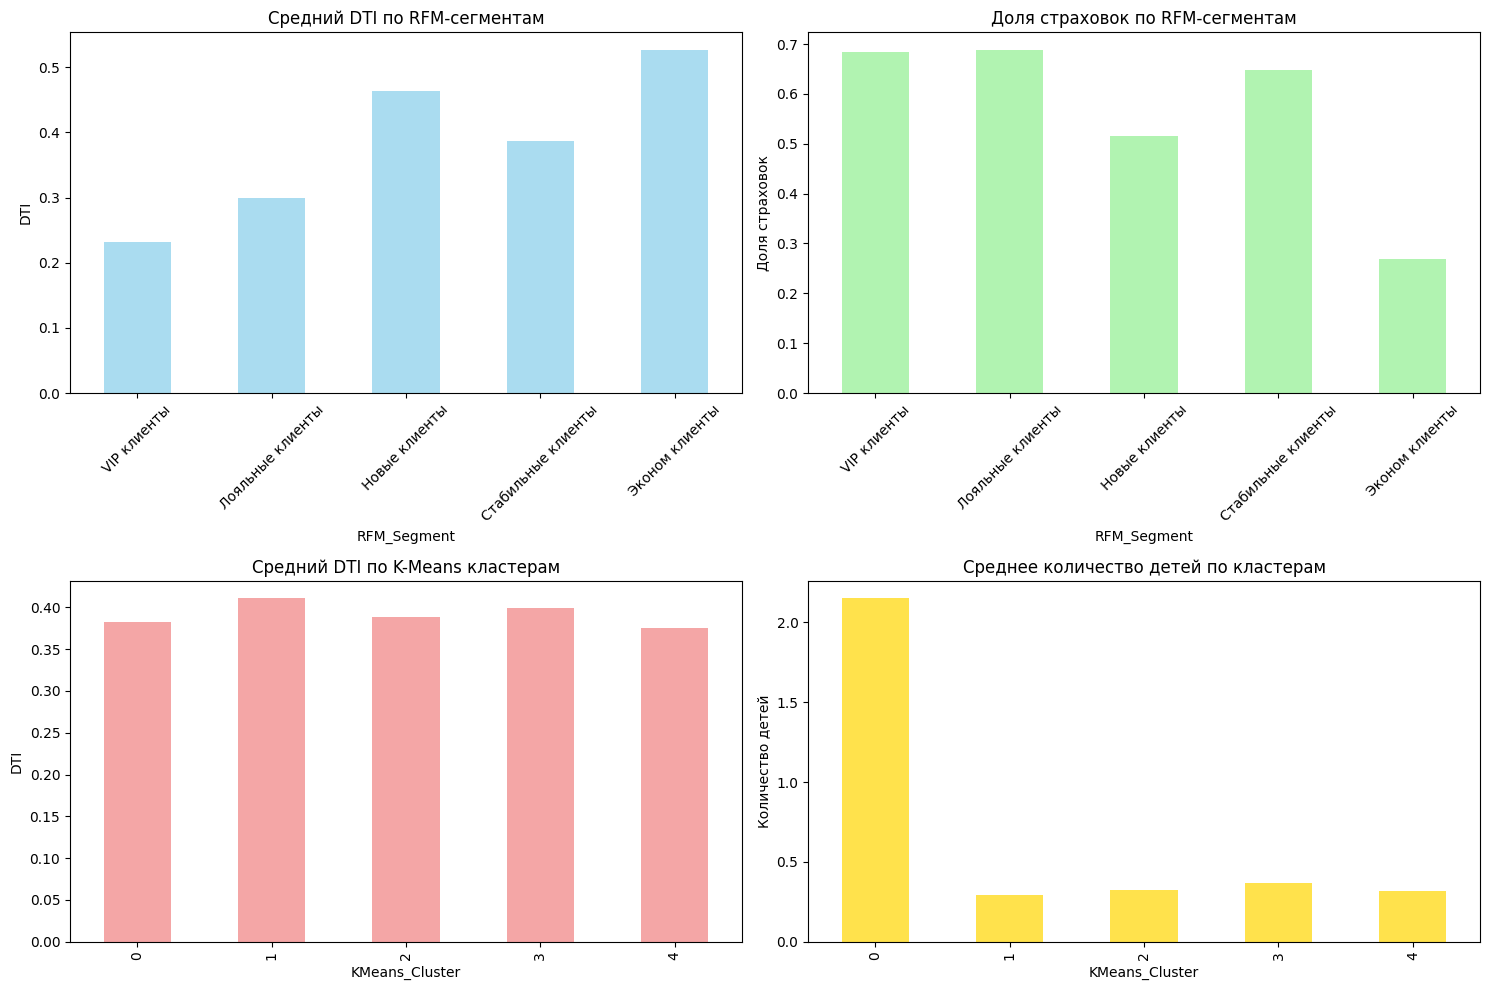

In [88]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

rfm_profiles[('DTI', 'mean')].plot(kind='bar', ax=axes[0,0], color='skyblue', alpha=0.7)
axes[0,0].set_title('Средний DTI по RFM-сегментам')
axes[0,0].set_ylabel('DTI')
axes[0,0].tick_params(axis='x', rotation=45)

rfm_profiles[('INSURANCE_FLAG', 'mean')].plot(kind='bar', ax=axes[0,1], color='lightgreen', alpha=0.7)
axes[0,1].set_title('Доля страховок по RFM-сегментам')
axes[0,1].set_ylabel('Доля страховок')
axes[0,1].tick_params(axis='x', rotation=45)

kmeans_profiles[('DTI', 'mean')].plot(kind='bar', ax=axes[1,0], color='lightcoral', alpha=0.7)
axes[1,0].set_title('Средний DTI по K-Means кластерам')
axes[1,0].set_ylabel('DTI')

kmeans_profiles[('FULL_AGE_CHILD_NUMBER', 'mean')].plot(kind='bar', ax=axes[1,1], color='gold', alpha=0.7)
axes[1,1].set_title('Среднее количество детей по кластерам')
axes[1,1].set_ylabel('Количество детей')

plt.tight_layout()
plt.show()